In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

from time_series.entities import Offsets
from time_series.preprocessing.generate_dataset import MakeDatasetFromDataFrame
from time_series.tensorflow.wrappers import compile_and_fit
from time_series.tensorflow.wrappers import apply_model
from time_series.plotting.plot_time_series import plot_time_series
from time_series.plotting.plot_single_time_series import PlotSingleTimeSeries
from time_series.tensorflow.analyse import plot_training
from time_series.sources.weather import get_weather_data
from time_series.entities import Data
from time_series.preprocessing.split_test_train import split_data
from time_series.helpers.dataset import one_shot_iterator
%load_ext autoreload
%autoreload 2

### Multi horizon time series
- We want to predict several timesteps ahead in future. 
- In principle there are two approaches to this problem:
     - **Autoregressive approaches** we only predict one timestep and then feed the result as feature to the next timestep
     - **Single shot predictions** all timesteps are predicted at once
- The goal of this notebook is to learn how to genereralize single output models to multi horizon models. So the models themselves will be pretty similar as to the previous notebook. The main difference will be the output layers. 

- Let's begin by getting the weather data, clean them and prepare the dataset for model input.
- We just import the functions from the previous notebook in order to avoid code duplication.

### Todo: 
- resnet

In [35]:
def impute_wind_velocities(df: DataFrame):
    cols = ['wv (m/s)', 'max. wv (m/s)']
    for col in cols:
        mask = df[col] == -9999
        df[col][mask] = 0.0
    return df


def make_dataset(offsets, shuffle_buffer_size=None): 
    """Wrapper to generate dataset"""
    return MakeDatasetFromDataFrame(offsets=offsets, 
                                    batch_size=32, 
                                    labels=["T (degC)"], 
                                    shuffle_buffer_size=shuffle_buffer_size)


early_stopping = EarlyStopping(monitor='val_loss',patience=2, mode='min')
optimizer = tf.optimizers.Adam()
mae = tf.metrics.MeanAbsoluteError()

def wrap_training(model, train, validation):
    """Wrapper for training"""
    return compile_and_fit(model, 
                           train, 
                           validation, 
                           epochs=20, 
                           optimizer=optimizer, 
                           callbacks=[early_stopping],
                           metrics=[mae],
                           verbose=1
                          )


def plot_overall_time_series(data: DataFrame, ds, offsets, model=None, x_lim=(datetime(2016, 5, 1), datetime(2016, 5, 2))):
    """Wrapper for plotting overall time series. REMOVE"""
    x_range = data.index[offsets.input_width:] # omitt label width
    plot_time_series(x_range, *apply_model(model, ds), "T scaled",
                     x_lim=x_lim,
                     style="o-")

In [36]:
# get data and impute missing
df = impute_wind_velocities(get_weather_data())

# train-validation-test split and normalization
data = split_data(df).normalize()

# parametrize time series data
offsets = Offsets(input_width=24, label_width=24, shift=24)  

# windowed dataset
ds = (data.on_train(make_dataset(offsets, 100000))
          .on_validation_and_test(make_dataset(offsets, None)))

Label width smaller than offset - not all labels are in the future


# One shot models
### Dense Neural Networks

In [37]:
out_steps = 24
n_features = 1

model = Sequential([
    tf.keras.Input(shape=(24, 14)),
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(24,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([out_steps, n_features])
])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 14)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 24)             360       
_________________________________________________________________
reshape_5 (Reshape)          (None, 24, 1)             0         
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1532/1532 [==============================] - 4s 2ms/step - loss: 0.2460 - mean_absolute_error: 0.3766 - val_loss: 0.1909 - val_mean_absolute_error: 0.3297
Epoch 2/20
1532/1532 [==============================] - 3s 2ms/step - loss: 0.2006 - mean_absolute_error: 0.3414 - val_loss: 0.1882 - val_mean_absolute_error: 0.3260
Epoch 3/20
1532/1532 [===========================

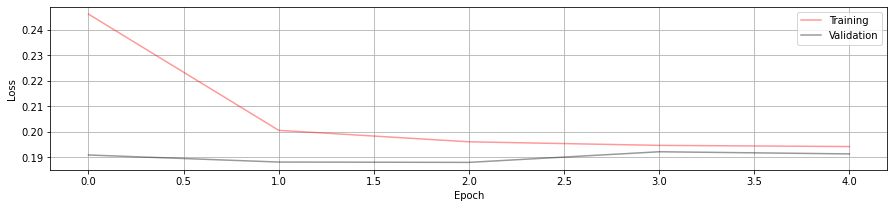

In [38]:
iterator = one_shot_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=ds.column_indices["T (degC)"], model=model)
plot_training(history)

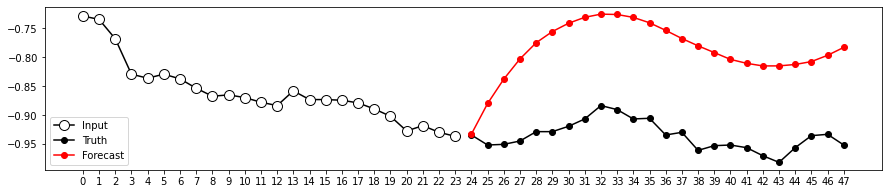

In [39]:
single_time_series_plotter(iterator)

In [40]:
# Add one layer
model = Sequential([
    tf.keras.Input(shape=(24, 14)),
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(24, kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([out_steps, n_features])])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 1, 14)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 512)            7680      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 24)             12312     
_________________________________________________________________
reshape_6 (Reshape)          (None, 24, 1)             0         
Total params: 19,992
Trainable params: 19,992
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1532/1532 [==============================] - 3s 2ms/step - loss: 0.2018 - mean_absolute_error: 0.3380 - val_loss: 0.1923 - val_mean_absolute_error: 0.3343
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0

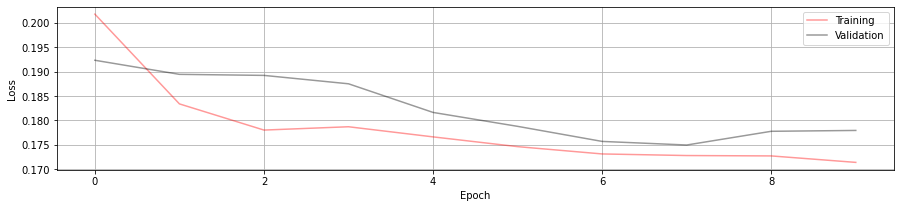

In [41]:
iterator = one_shot_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=ds.column_indices["T (degC)"], model=model)
plot_training(history)

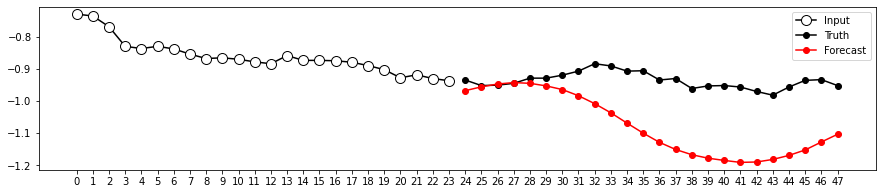

In [42]:
single_time_series_plotter(iterator)

In [43]:
# Add one layer
model = Sequential([
    tf.keras.Input(shape=(24, 14)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(24, kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([out_steps, n_features])])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 336)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               172544    
_________________________________________________________________
dense_11 (Dense)             (None, 24)                12312     
_________________________________________________________________
reshape_7 (Reshape)          (None, 24, 1)             0         
Total params: 184,856
Trainable params: 184,856
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.3379 - mean_absolute_error: 0.3615 - val_loss: 0.1108 - val_mean_absolute_error: 0.2543
Epoch 2/20
1532/1532 [==============================] - 5s 3ms/step - loss:

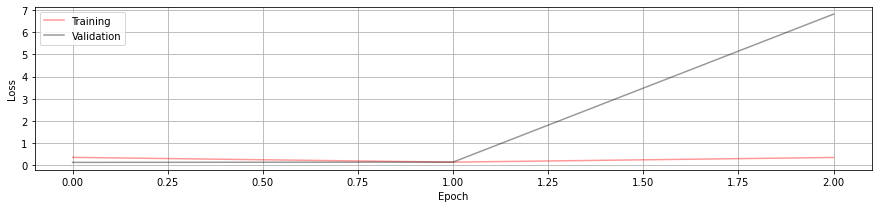

In [44]:
iterator = one_shot_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=ds.column_indices["T (degC)"], model=model)
plot_training(history)

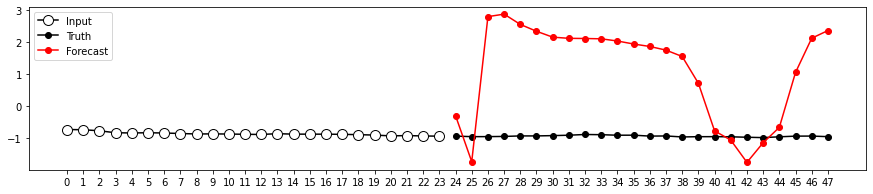

In [45]:
single_time_series_plotter(iterator)

### Convolutional Neural Networks

In [46]:
conv_width = 3
model = Sequential([
    tf.keras.Input(shape=(24, 14)),
    tf.keras.layers.Lambda(lambda x: x[:, -conv_width:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(conv_width)),
    tf.keras.layers.Dense(out_steps * n_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([out_steps, n_features])
])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 3, 14)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 256)            11008     
_________________________________________________________________
dense_12 (Dense)             (None, 1, 24)             6168      
_________________________________________________________________
reshape_8 (Reshape)          (None, 24, 1)             0         
Total params: 17,176
Trainable params: 17,176
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.1893 - mean_absolute_error: 0.6902 - val_loss: 0.1821 - val_mean_absolute_error: 0.3252
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0

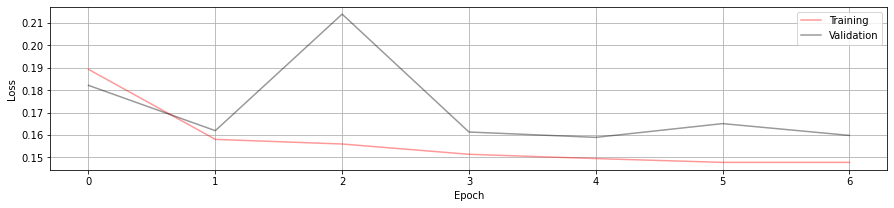

In [47]:
iterator = one_shot_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=ds.column_indices["T (degC)"], model=model)
plot_training(history)

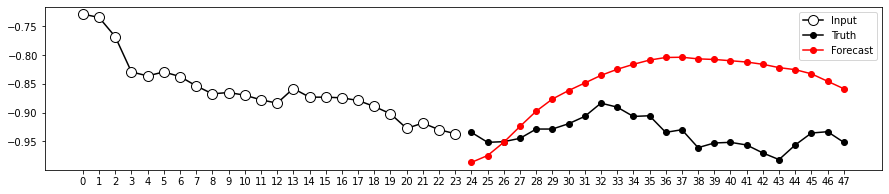

In [48]:
single_time_series_plotter(iterator)

### LSTM Model

In [50]:
model = Sequential([
    tf.keras.Input(shape=(24, 14)),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(out_steps * n_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([out_steps, n_features])
])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_14 (Dense)             (None, 24)                792       
_________________________________________________________________
reshape_10 (Reshape)         (None, 24, 1)             0         
Total params: 6,808
Trainable params: 6,808
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1532/1532 [==============================] - 18s 12ms/step - loss: 0.1386 - mean_absolute_error: 0.2854 - val_loss: 0.1061 - val_mean_absolute_error: 0.2463
Epoch 2/20
1532/1532 [==============================] - 13s 9ms/step - loss: 0.0997 - mean_absolute_error: 0.2396 - val_loss: 0.0975 - val_mean_absolute_error: 0.2342
Epoch 3/20
1532/1532 [===================

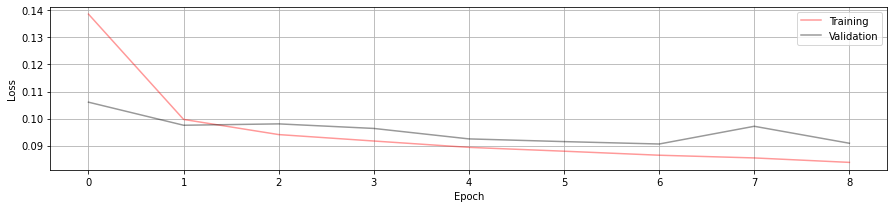

In [51]:
iterator = one_shot_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=ds.column_indices["T (degC)"], model=model)
plot_training(history)

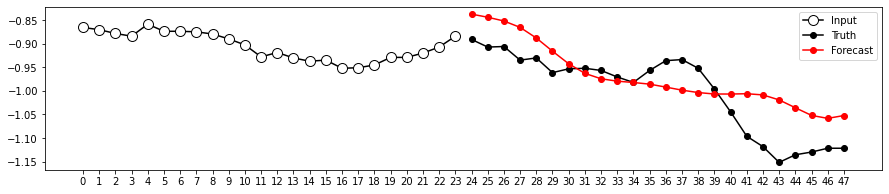

In [61]:
single_time_series_plotter(iterator)